In [2]:

# Import and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load data
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("EXPLORATORY DATA ANALYSIS - TELCO CHURN")

# Basic info
print(f"\n Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n Column Names & Types:")
print(df.dtypes)

# First few rows
print(f"\n First 5 Rows:")
print(df.head())

# Summary statistics
print(f"\n Summary Statistics:")
print(df.describe())

EXPLORATORY DATA ANALYSIS - TELCO CHURN

 Dataset Shape: 7043 rows × 21 columns

 Column Names & Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

 First 5 Rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0  

In [3]:

# DATA QUALITY & MISSING VALUES

# Missing values
print("\n Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else " No missing values")

# Memory usage
print(f"\n Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

# Data types
print(f"\n Data Types Breakdown:")
print(f"  • Numeric: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"  • Categorical: {df.select_dtypes(include=['object']).shape[1]}")


 Missing Values:
 No missing values

 Memory Usage: 1.13 MB

 Data Types Breakdown:
  • Numeric: 3
  • Categorical: 18


TARGET VARIABLE: CHURN

Churn Distribution:
   No Churn: 5174 customers (73.46%)
   Churn: 1869 customers (26.54%)
   Imbalance Ratio: 2.77:1


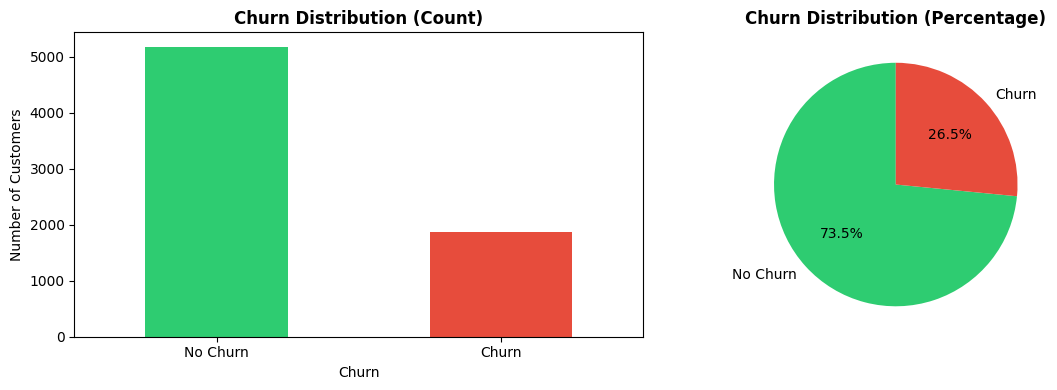

In [4]:

# Churn Analysis

print("TARGET VARIABLE: CHURN")

# Churn distribution
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print(f"\nChurn Distribution:")
print(f"   No Churn: {churn_counts['No']} customers ({churn_pct['No']:.2f}%)")
print(f"   Churn: {churn_counts['Yes']} customers ({churn_pct['Yes']:.2f}%)")
print(f"   Imbalance Ratio: {churn_counts['No']/churn_counts['Yes']:.2f}:1")

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Count plot
churn_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Churn Distribution (Count)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Customers')
ax1.set_xticklabels(['No Churn', 'Churn'], rotation=0)

# Pie chart
ax2.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', 
        colors=['#2ecc71', '#e74c3c'], startangle=90)
ax2.set_title('Churn Distribution (Percentage)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

FEATURE ANALYSIS

 Tenure (in months) vs Churn:
        count   mean    std  min   25%   50%   75%   max
Churn                                                   
No     5174.0  37.57  24.11  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.98  19.53  1.0   2.0  10.0  29.0  72.0


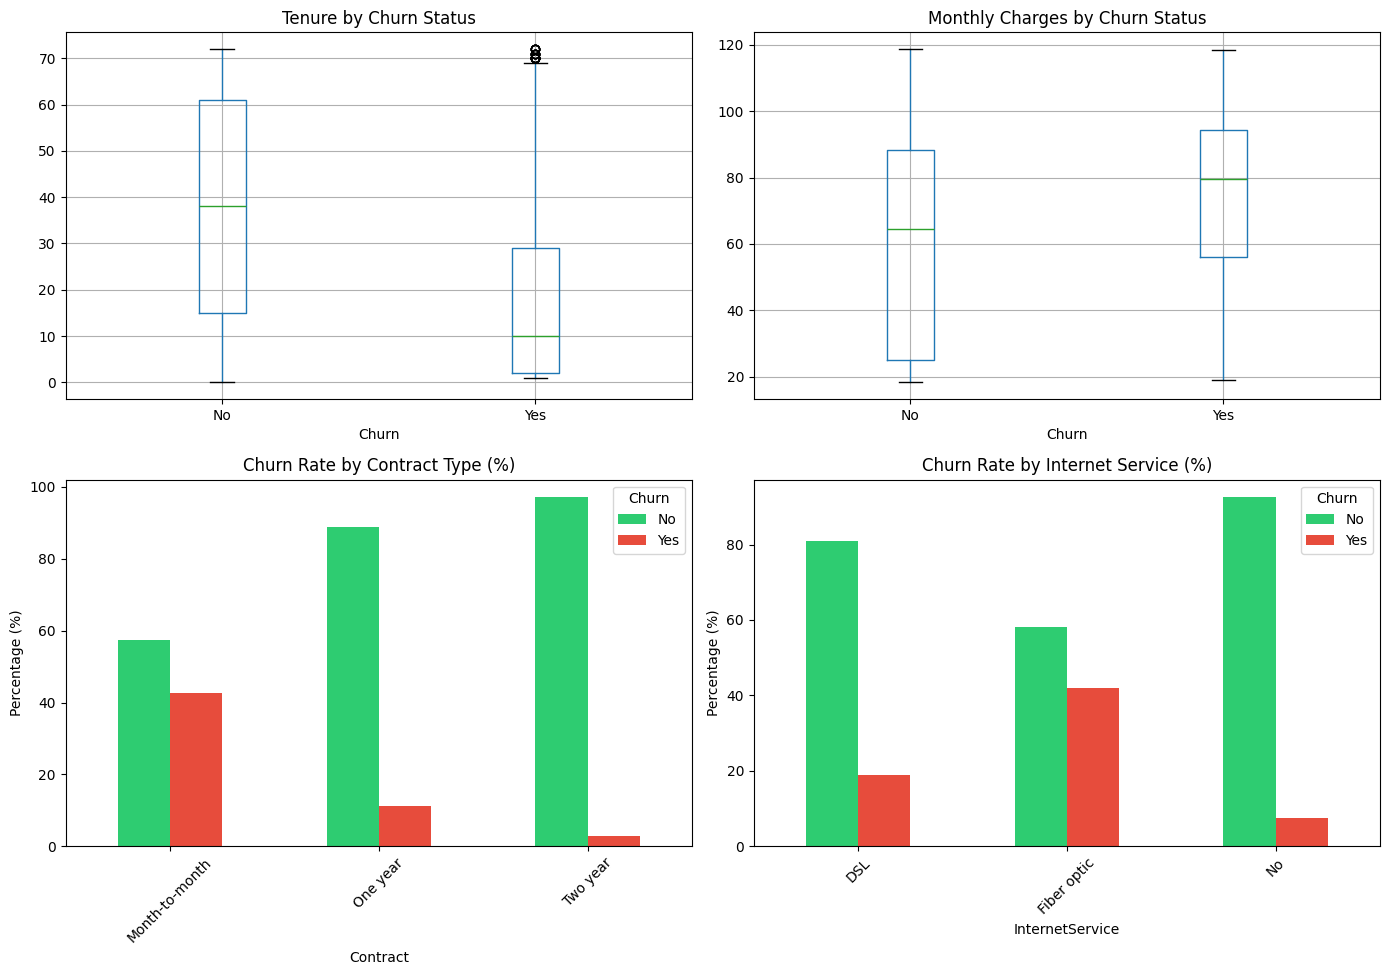

  • Tenure is strongly inversely correlated with churn
  • Month-to-month contracts have highest churn rate
  • Fiber optic internet has higher churn than DSL


In [5]:

# FEATURE RELATIONSHIPS WITH CHURN

print("FEATURE ANALYSIS")

# Tenure vs Churn
print("\n Tenure (in months) vs Churn:")
print(df.groupby('Churn')['tenure'].describe().round(2))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Tenure by churn
df.boxplot(column='tenure', by='Churn', ax=axes[0, 0])
axes[0, 0].set_title('Tenure by Churn Status')
axes[0, 0].set_xlabel('Churn')

# 2. Monthly Charges by churn
df.boxplot(column='MonthlyCharges', by='Churn', ax=axes[0, 1])
axes[0, 1].set_title('Monthly Charges by Churn Status')
axes[0, 1].set_xlabel('Churn')

# 3. Contract type vs churn
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
contract_churn.plot(kind='bar', ax=axes[1, 0], color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_title('Churn Rate by Contract Type (%)')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# 4. Internet Service vs churn
internet_churn = pd.crosstab(df['InternetService'], df['Churn'], normalize='index') * 100
internet_churn.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'])
axes[1, 1].set_title('Churn Rate by Internet Service (%)')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

plt.suptitle('')
plt.tight_layout()
plt.show()


print("  • Tenure is strongly inversely correlated with churn")
print("  • Month-to-month contracts have highest churn rate")
print("  • Fiber optic internet has higher churn than DSL")

In [6]:



 #IMPORTS & CONFIGURATION

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data processing
from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, precision_score, 
    recall_score, accuracy_score
)

# Explainability
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model persistence
import joblib

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



In [7]:
#  Feature Engineering and Encoding

print("FEATURE ENGINEERING")

# Convert TotalCharges to numeric BEFORE one-hot encoding
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Create log-transformed version
df['TotalCharges_log'] = np.log1p(df['TotalCharges'])

# Binary columns
binary_cols = ['PhoneService', 'PaperlessBilling', 'Partner', 'Dependents']
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# One-hot encoding (do this AFTER TotalCharges conversion)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Feature engineering: Tenure buckets (after one-hot encoding)
df['tenure_0_6m'] = (df['tenure'] <= 6).astype(int)
df['tenure_6_12m'] = ((df['tenure'] > 6) & (df['tenure'] <= 12)).astype(int)
df['tenure_1_2y'] = ((df['tenure'] > 12) & (df['tenure'] <= 24)).astype(int)
df['tenure_2y_plus'] = (df['tenure'] > 24).astype(int)

print(f" Binary columns converted: {binary_cols}")
print(f" One-hot encoding applied (drop_first=True)")
print(f" Tenure buckets created")
print(f" TotalCharges log-transformed")
print(f" Final shape: {df.shape}\n")

FEATURE ENGINEERING
 Binary columns converted: ['PhoneService', 'PaperlessBilling', 'Partner', 'Dependents']
 One-hot encoding applied (drop_first=True)
 Tenure buckets created
 TotalCharges log-transformed
 Final shape: (7043, 7078)



In [8]:
# Preparing data for modeling




# 1. Drop customerID if it exists
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# 2. Fix TotalCharges if it's still text (prevents errors)
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# 3. Handle potential missing or non-numeric 'Churn' column
target_col = 'Churn'
if 'Churn' not in df.columns:
    if 'Churn_Yes' in df.columns:
        
        target_col = 'Churn_Yes'
    else:
        raise ValueError("Could not find 'Churn' or 'Churn_Yes' column. Please run Sections 2-4.")

# 4. Ensure target is numeric
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].map({'Yes': 1, 'No': 0})

# 5. AUTO-FIX: Handle any remaining categorical columns (like 'gender')
# This catches anything that wasn't encoded in Section 4
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if len(cat_cols) > 0:
    
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Separate features and target
X = df.drop(target_col, axis=1) # Features
y = df[target_col] # Target

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
) # 80-20 stratified split

print(f" Train-test split (80-20 stratified):")
print(f"   Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Train churn rate: {y_train.sum()/len(y_train)*100:.2f}%")
print(f"   Test churn rate: {y_test.sum()/len(y_test)*100:.2f}%\n")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Features scaled (StandardScaler)")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(f" Class weights (for imbalance handling):")
print(f"   No Churn (0): {class_weights[0]:.4f}")
print(f"   Churn (1): {class_weights[1]:.4f}\n")

 Train-test split (80-20 stratified):
   Train: 5634 samples (80.0%)
   Test: 1409 samples (20.0%)
   Train churn rate: 26.54%
   Test churn rate: 26.54%

 Features scaled (StandardScaler)
 Class weights (for imbalance handling):
   No Churn (0): 0.6806
   Churn (1): 1.8843



In [9]:
 # LOGISTIC REGRESSION (BASELINE)


print(" LOGISTIC REGRESSION (BASELINE)")


print("\nTraining with 5-fold cross-validation...\n")

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

print(f"✓ Cross-Validation Results:")
print(f"  • Mean ROC-AUC: {cv_scores_lr.mean():.4f}")
print(f"  • Std Dev: {cv_scores_lr.std():.4f}")
print(f"  • Min/Max: {cv_scores_lr.min():.4f} / {cv_scores_lr.max():.4f}")

if cv_scores_lr.std() > 0.05:
    print(f"  ⚠️  High variance - possible instability\n")
else:
    print(f"  ✓ Low variance - stable model\n")

# Train final model
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

print("Test Set Performance:")
print(f"  • Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"  • Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"  • F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"  • ROC-AUC: {roc_auc_score(y_test, y_pred_proba_lr):.4f}\n")


 LOGISTIC REGRESSION (BASELINE)

Training with 5-fold cross-validation...

✓ Cross-Validation Results:
  • Mean ROC-AUC: 0.8443
  • Std Dev: 0.0101
  • Min/Max: 0.8324 / 0.8590
  ✓ Low variance - stable model

Test Set Performance:
  • Accuracy: 0.7928
  • Precision: 0.6653
  • Recall: 0.4412
  • F1-Score: 0.5305
  • ROC-AUC: 0.8433



In [10]:
#   RANDOM FOREST 


print(" - RANDOM FOREST (WITH TUNING)")



# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt', 'log2']
}

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0
)
rf_grid.fit(X_train, y_train)


print(f"\nBest Parameters:")
for param, value in rf_grid.best_params_.items():
    print(f"  • {param}: {value}")
print(f"\nBest CV ROC-AUC Score: {rf_grid.best_score_:.4f}\n")

# Best model
rf_model = rf_grid.best_estimator_
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Test Set Performance:")
print(f"  • Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"  • Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"  • Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"  • F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"  • ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}\n")

 - RANDOM FOREST (WITH TUNING)

Best Parameters:
  • max_depth: 10
  • max_features: sqrt
  • min_samples_leaf: 4
  • min_samples_split: 10
  • n_estimators: 200

Best CV ROC-AUC Score: 0.8299

Test Set Performance:
  • Accuracy: 0.7360
  • Precision: 0.5017
  • Recall: 0.7914
  • F1-Score: 0.6141
  • ROC-AUC: 0.8241



In [11]:
#MODEL 3 - GRADIENT BOOSTING (ADVANCED)

print("MODEL 3 - GRADIENT BOOSTING (REGULARIZED)")


gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,      # Low LR reduces overfitting
    max_depth=5,             # Shallow trees
    min_samples_split=10,
    subsample=0.8,           # Stochastic boosting
    random_state=42
)

# Cross-validation
cv_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=cv, scoring='roc_auc')

print(f"✓ Cross-Validation Results:")
print(f"   Mean ROC-AUC: {cv_scores_gb.mean():.4f}")
print(f"  Std Dev: {cv_scores_gb.std():.4f}\n")
# Train
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

print("Test Set Performance:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"   F1-Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba_gb):.4f}\n")

MODEL 3 - GRADIENT BOOSTING (REGULARIZED)
✓ Cross-Validation Results:
   Mean ROC-AUC: 0.8491
  Std Dev: 0.0126

Test Set Performance:
   Accuracy: 0.8055
  Precision: 0.6748
   Recall: 0.5160
   F1-Score: 0.5848
  ROC-AUC: 0.8476



In [12]:
 #MODEL COMPARISON


print("MODEL COMPARISON & SELECTION")


comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_gb)
    ],
    'Precision': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_gb)
    ],
    'Recall': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_gb)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_gb)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_lr),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_gb)
    ]
})

print("\n" + comparison_df.to_string(index=False) + "\n")

# Best model
best_idx = comparison_df['ROC-AUC'].idxmax()
best_name = comparison_df.iloc[best_idx]['Model']
best_auc = comparison_df.iloc[best_idx]['ROC-AUC']

print(f" BEST MODEL: {best_name}")
print(f"   ROC-AUC: {best_auc:.4f}\n")

if best_idx == 0:
    best_model_final = lr_model
    y_pred_best = y_pred_lr
    y_pred_proba_best = y_pred_proba_lr
    X_test_for_shap = X_test_scaled
elif best_idx == 1:
    best_model_final = rf_model
    y_pred_best = y_pred_rf
    y_pred_proba_best = y_pred_proba_rf
    X_test_for_shap = X_test
else:
    best_model_final = gb_model
    y_pred_best = y_pred_gb
    y_pred_proba_best = y_pred_proba_gb
    X_test_for_shap = X_test

MODEL COMPARISON & SELECTION

              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.792761   0.665323 0.441176  0.530547 0.843292
      Random Forest  0.735983   0.501695 0.791444  0.614108 0.824067
  Gradient Boosting  0.805536   0.674825 0.516043  0.584848 0.847583

 BEST MODEL: Gradient Boosting
   ROC-AUC: 0.8476



In [13]:
 # FEATURE IMPORTANCE


print("FEATURE IMPORTANCE")


if best_idx in [1, 2]:  # Tree-based
    feature_imp_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model_final.feature_importances_
    }).sort_values('Importance', ascending=False)
else:  # Logistic Regression
    feature_imp_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(best_model_final.coef_[0])
    }).sort_values('Importance', ascending=False)

print("Top 15 Features:")
for i, row in feature_imp_df.head(15).iterrows():
    print(f"  {i+1:2d}. {row['Feature']:35s} {row['Importance']:.4f}")


FEATURE IMPORTANCE
Top 15 Features:
   4. tenure                              0.2393
  7055. InternetService_Fiber optic         0.1672
   7. MonthlyCharges                      0.0794
  7072. PaymentMethod_Electronic check      0.0699
   9. TotalCharges_log                    0.0414
   8. TotalCharges                        0.0392
  7070. Contract_Two year                   0.0326
  7069. Contract_One year                   0.0301
   6. PaperlessBilling                    0.0189
  7058. OnlineSecurity_Yes                  0.0138
  7064. TechSupport_Yes                     0.0123
  7054. MultipleLines_Yes                   0.0115
  7068. StreamingMovies_Yes                 0.0075
   1. SeniorCitizen                       0.0072
   3. Dependents                          0.0051


In [14]:

#  SHAP EXPLAINABILITY


print("SHAP EXPLAINABILITY")

if best_idx in [1, 2]:
    explainer = shap.TreeExplainer(best_model_final) # Tree-based models
    print("✓ TreeExplainer initialized")
else:
    explainer = shap.KernelExplainer(best_model_final.predict_proba, X_train_scaled[:100]) #
    print("✓ KernelExplainer initialized")

shap_values = explainer.shap_values(X_test_for_shap)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f"✓ SHAP values calculated: {shap_values.shape}\n")


SHAP EXPLAINABILITY
✓ TreeExplainer initialized
✓ SHAP values calculated: (1409, 7077)



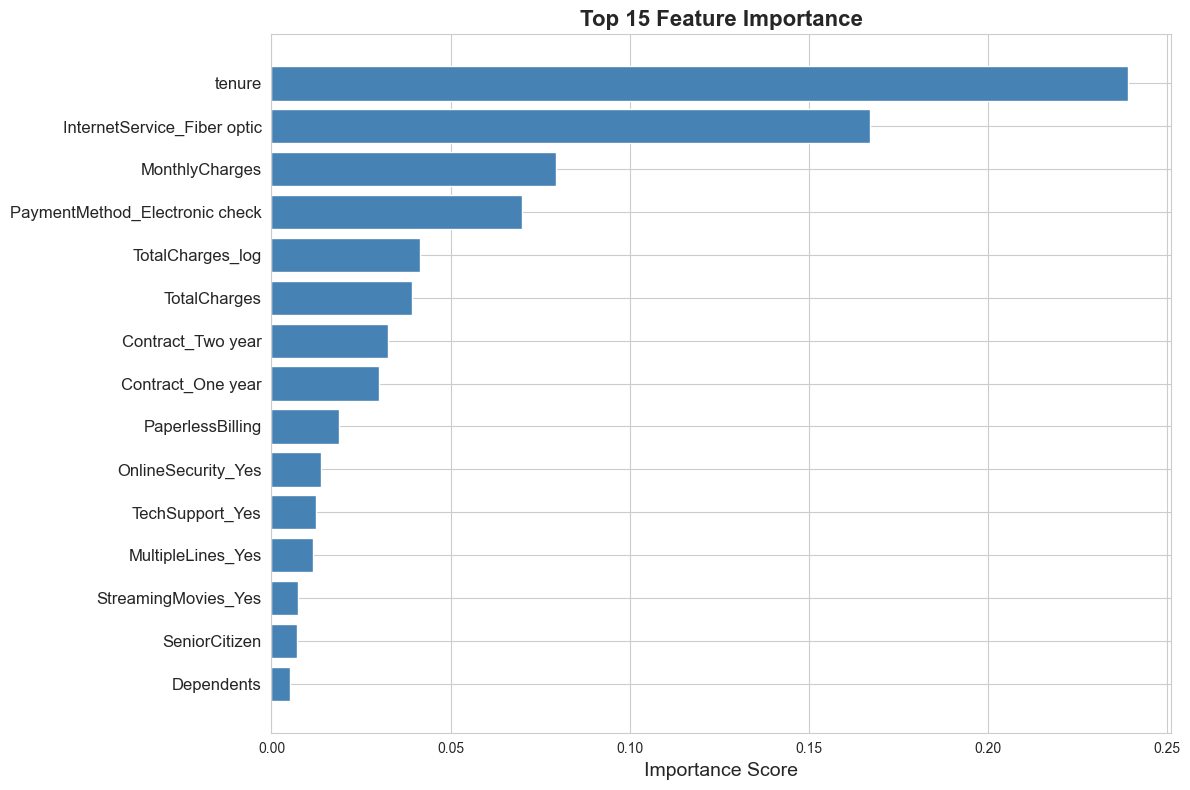

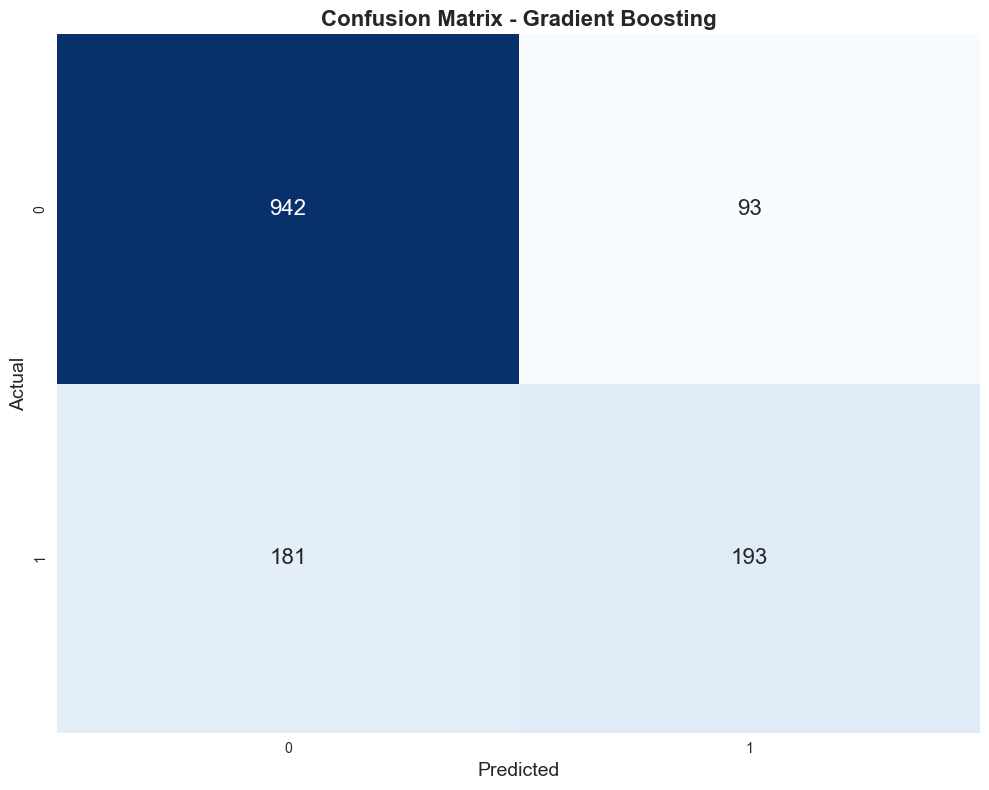

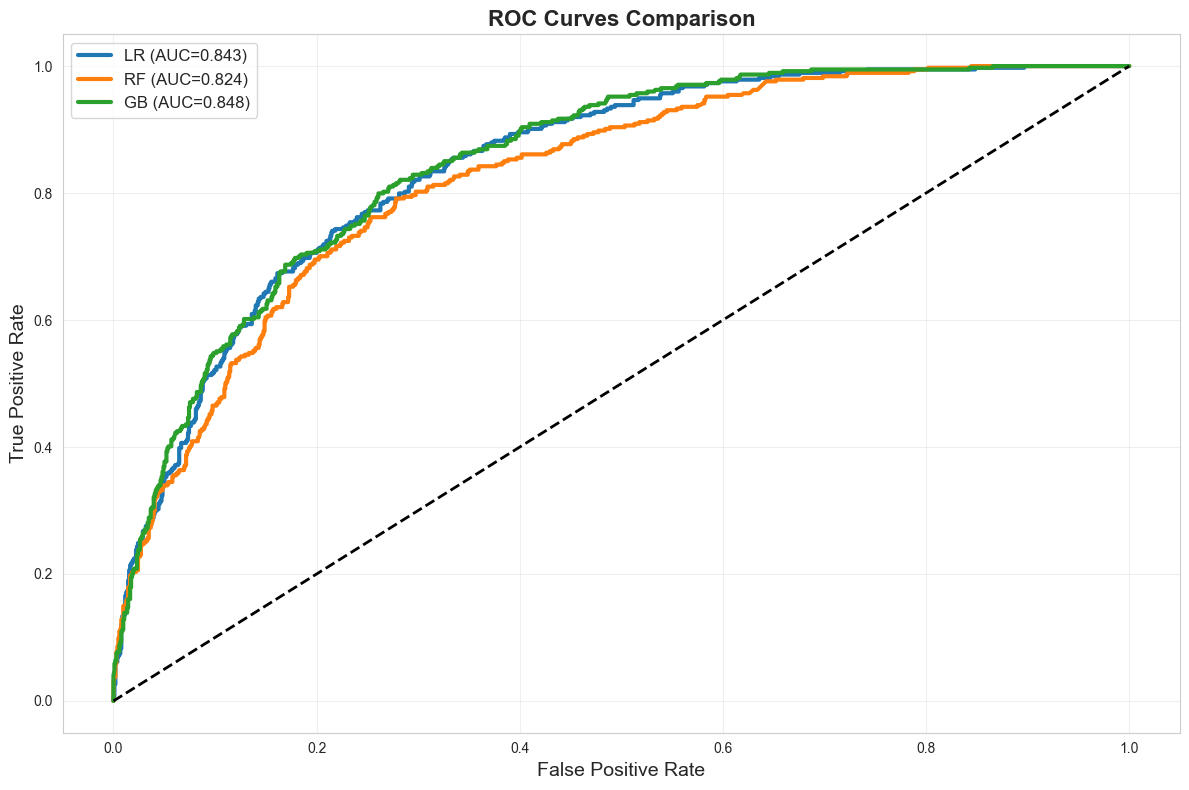

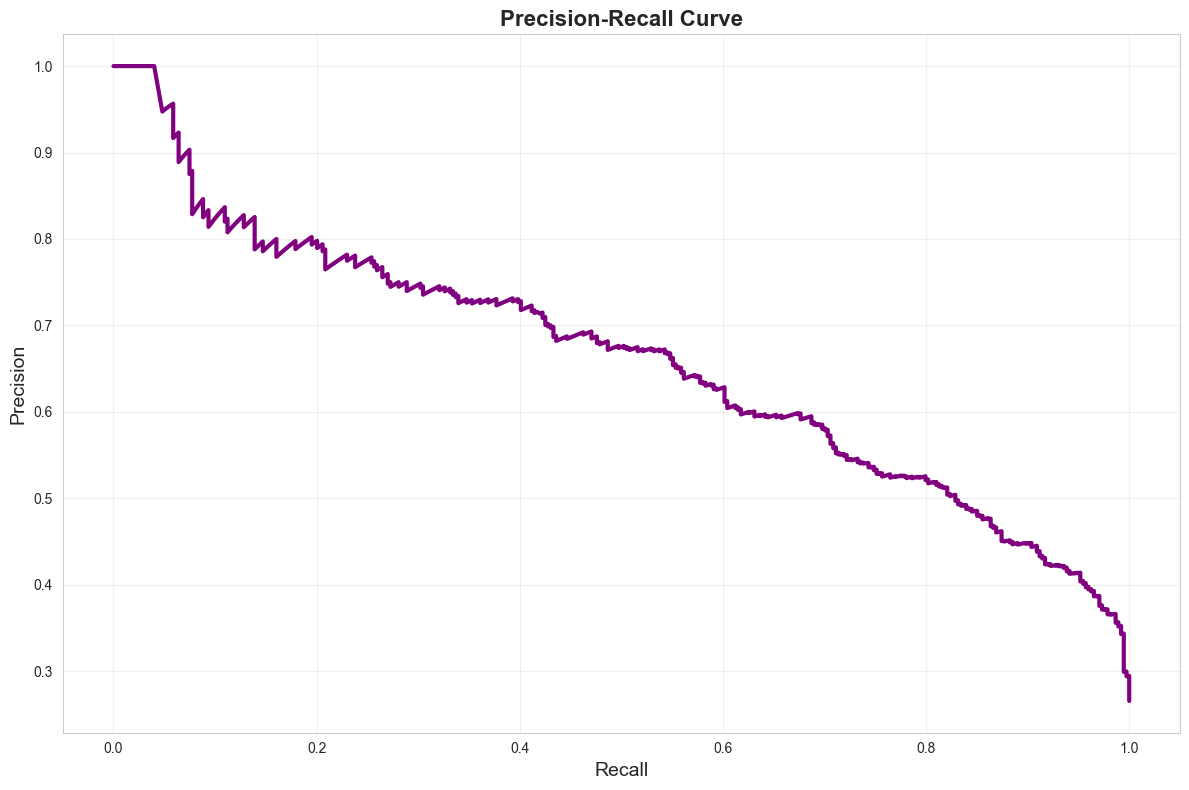

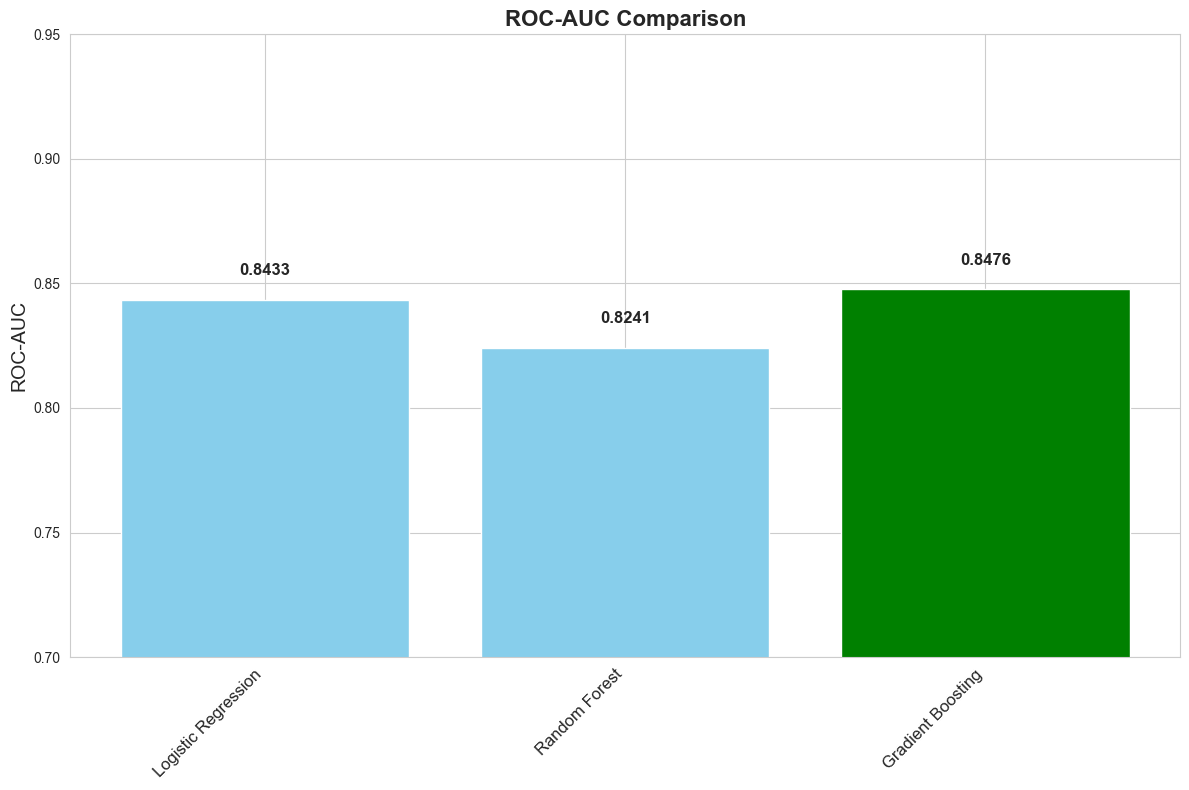

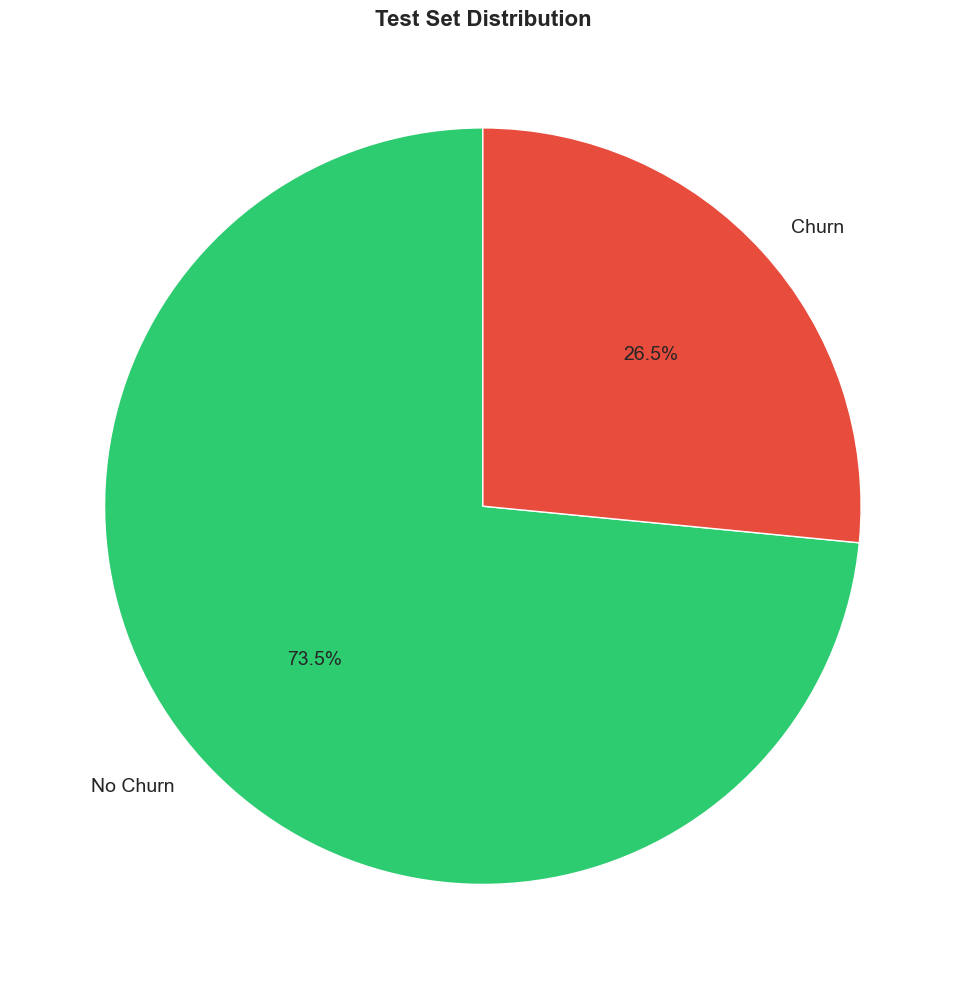

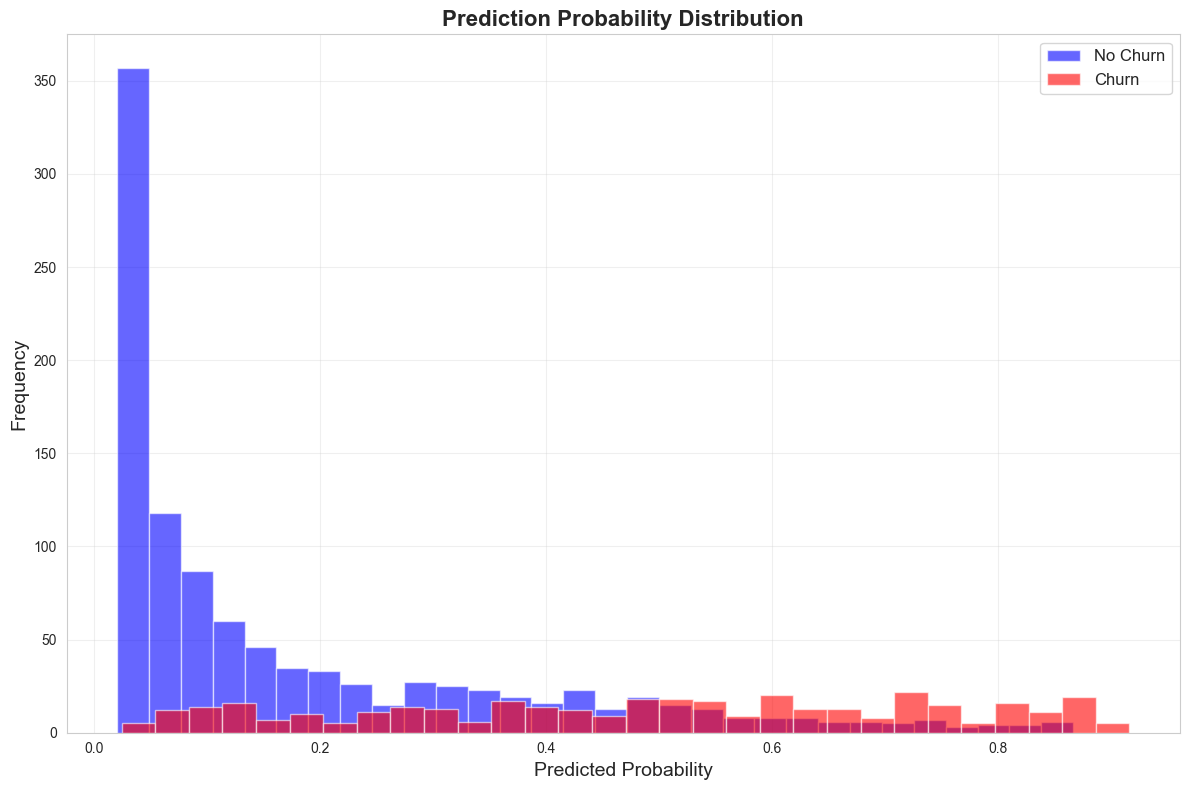

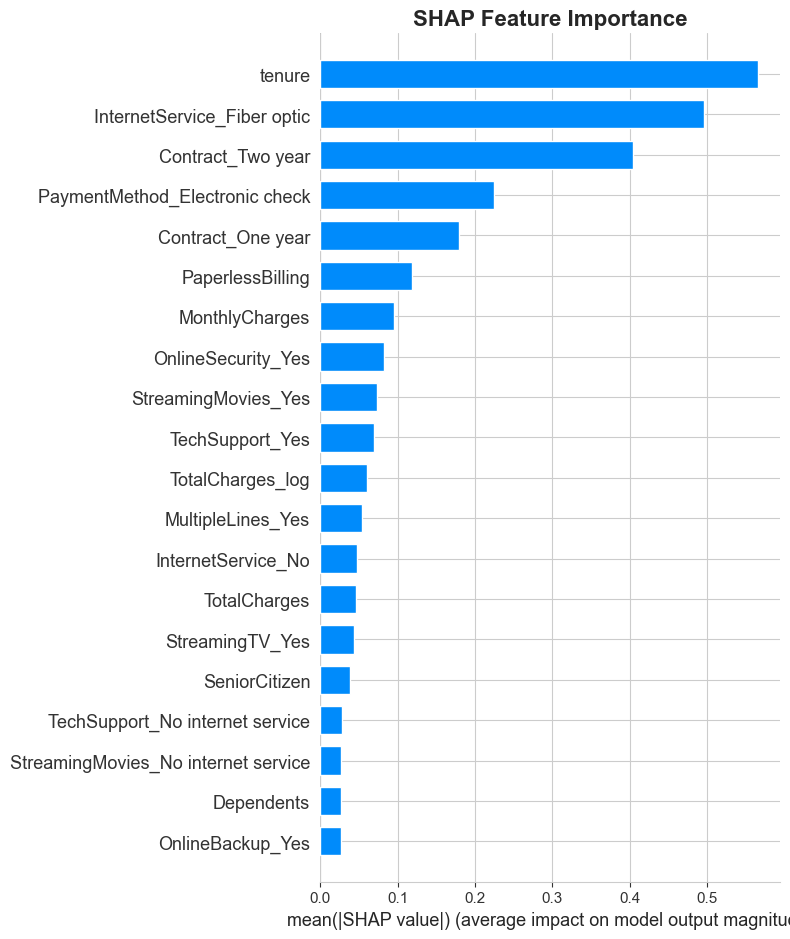

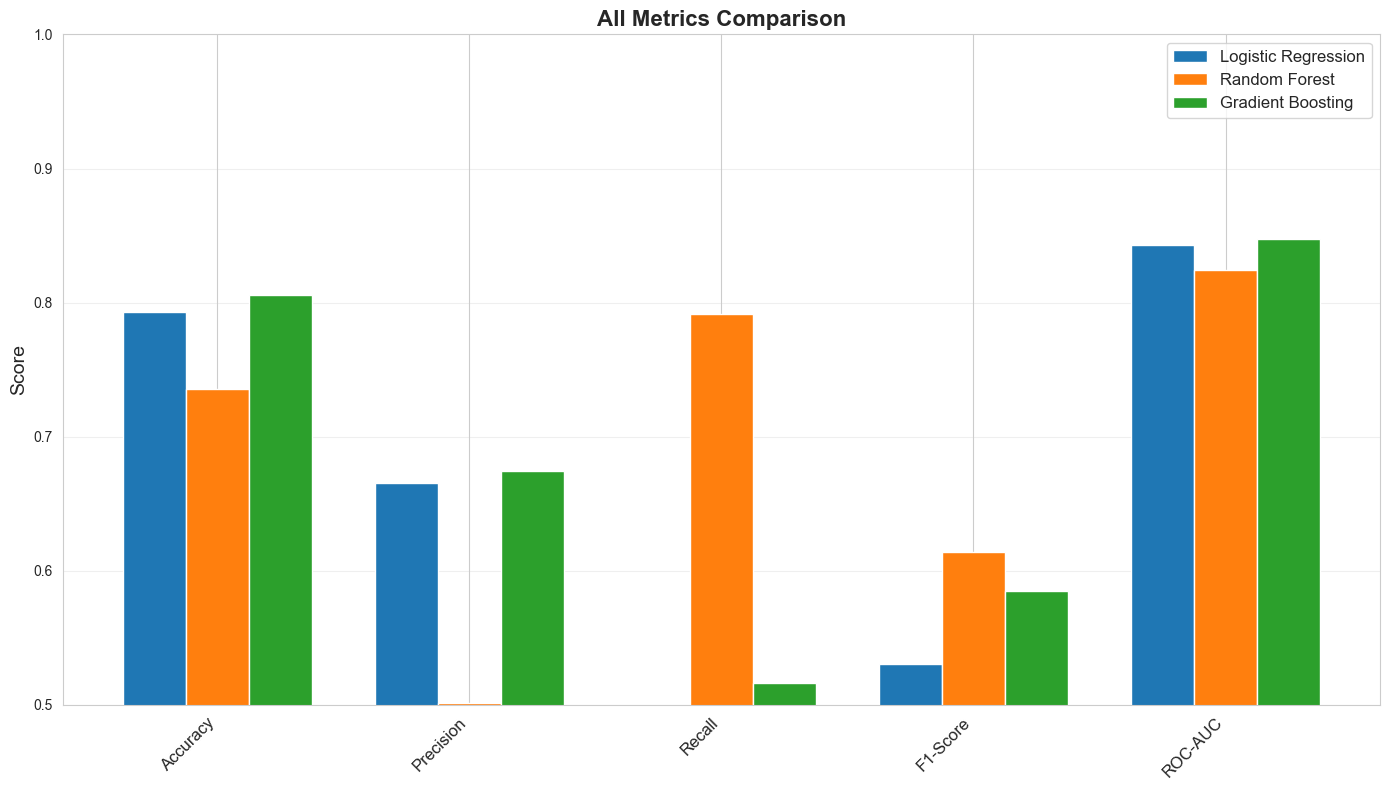


Generating SHAP waterfall plot...

⚠️  SHAP waterfall plot skipped: waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you 


<Figure size 1400x1000 with 0 Axes>

In [23]:
#  VISUALIZATIONS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap



# 1. Feature Importance
plt.figure(figsize=(12, 8))
top_feat = feature_imp_df.head(15)
plt.barh(range(len(top_feat)), top_feat['Importance'], color='steelblue')
plt.yticks(range(len(top_feat)), top_feat['Feature'], fontsize=12)
plt.title('Top 15 Feature Importance', fontweight='bold', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
plt.title(f'Confusion Matrix - {best_name}', fontweight='bold', fontsize=16)
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.tight_layout()
plt.show()

# 3. ROC Curves Comparison
plt.figure(figsize=(12, 8))
for name, y_pred_proba in [
    ('LR', y_pred_proba_lr),
    ('RF', y_pred_proba_rf),
    ('GB', y_pred_proba_gb)
]:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.title('ROC Curves Comparison', fontweight='bold', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Precision-Recall Curve
plt.figure(figsize=(12, 8))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best)
plt.plot(recall, precision, color='purple', linewidth=3)
plt.title('Precision-Recall Curve', fontweight='bold', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. ROC-AUC Comparison
plt.figure(figsize=(12, 8))
colors = ['green' if i == best_idx else 'skyblue' for i in range(3)]
plt.bar(comparison_df['Model'], comparison_df['ROC-AUC'], color=colors)
plt.title('ROC-AUC Comparison', fontweight='bold', fontsize=16)
plt.ylabel('ROC-AUC', fontsize=14)
plt.ylim([0.7, 0.95])
for i, v in enumerate(comparison_df['ROC-AUC']):
    plt.text(i, v+0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# 6. Test Set Distribution
plt.figure(figsize=(10, 10))
class_dist = y_test.value_counts()
plt.pie(class_dist, labels=['No Churn', 'Churn'], autopct='%1.1f%%',
        colors=['#2ecc71', '#e74c3c'], startangle=90, textprops={'fontsize': 14})
plt.title('Test Set Distribution', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# 7. Prediction Probability Distribution
plt.figure(figsize=(12, 8))
plt.hist(y_pred_proba_best[y_test == 0], bins=30, alpha=0.6, 
         label='No Churn', color='blue')
plt.hist(y_pred_proba_best[y_test == 1], bins=30, alpha=0.6, 
         label='Churn', color='red')
plt.title('Prediction Probability Distribution', fontweight='bold', fontsize=16)
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 8. SHAP Feature Importance Summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_for_shap, plot_type="bar", show=False)
plt.title('SHAP Feature Importance', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

# 9. All Metrics Comparison
plt.figure(figsize=(14, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics))
width = 0.25

for i, model_name in enumerate(['Logistic Regression', 'Random Forest', 'Gradient Boosting']):
    values = comparison_df[comparison_df['Model'] == model_name][metrics].values[0]
    plt.bar(x_pos + i*width, values, width, label=model_name)

plt.title('All Metrics Comparison', fontweight='bold', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xticks(x_pos + width, metrics, rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=12)
plt.ylim([0.5, 1.0])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# SHAP Waterfall Plot (Individual Example)
print("\nGenerating SHAP waterfall plot...\n")
try:
    # Get expected value and SHAP values for first sample
    if best_idx != 0:  # Tree-based models
        expected = explainer.expected_value
        shap_val = shap_values[0]
    else:  # Logistic Regression
        expected = explainer.expected_value[1]
        shap_val = shap_values[0]
    
    # Get first test sample as DataFrame
    if hasattr(X_test_for_shap, 'iloc'):
        first_sample = X_test_for_shap.iloc[0]
    else:
        first_sample = pd.DataFrame(X_test_for_shap[0:1])[0]
    
    # Create waterfall plot
    plt.figure(figsize=(14, 10))
    shap.plots._waterfall.waterfall_legacy(
        expected,
        shap_val,
        first_sample,
        feature_names=X.columns.tolist()
    )
    plt.title('SHAP Waterfall - Individual Prediction Example', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"⚠️  SHAP waterfall plot skipped: {str(e)[:100]}")

In [16]:
#  SAVE ARTIFACTS


print(" SAVING MODELS & ARTIFACTS")

# Save model
joblib.dump(best_model_final, '../models/best_model.pkl')
print("✓ Saved: models/best_model.pkl")

# Save scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("✓ Saved: models/scaler.pkl")

# Save comparison
comparison_df.to_csv('../models/model_comparison.csv', index=False)
print("✓ Saved: models/model_comparison.csv")

# Save feature importance
feature_imp_df.to_csv('../models/feature_importance.csv', index=False)
print("✓ Saved: models/feature_importance.csv")

 SAVING MODELS & ARTIFACTS
✓ Saved: models/best_model.pkl
✓ Saved: models/scaler.pkl
✓ Saved: models/model_comparison.csv
✓ Saved: models/feature_importance.csv


In [25]:
# FINAL SUMMARY

print(" FINAL SUMMARY & INSIGHTS")

print("PROJECT SUMMARY:")
print("-" * 80)
print(f"✓ Dataset: {len(df)} Telco customers")
# FIXED: Use 'y' instead of df['Churn'] as 'Churn' column might be dropped from df
print(f"✓ Churn Rate: {(y.sum()/len(y)*100):.2f}%")
print(f"✓ Features: {X.shape[1]} (after preprocessing)")
print(f"✓ Train-Test: 80-20 stratified split")
print(f"✓ Best Model: {best_name}")
print(f"✓ ROC-AUC Score: {best_auc:.4f}\n")

print("TOP 3 CHURN PREDICTORS (SHAP):")
print("-" * 80)
for i, (_, row) in enumerate(feature_imp_df.head(3).iterrows(), 1):
    print(f"{i}. {row['Feature']:35s} → {row['Importance']:.4f}")

print("\n\nMODEL PERFORMANCE METRICS:")
print("-" * 80)
print(f"✓ Accuracy:  {accuracy_score(y_test, y_pred_best):.4f}")
print(f"✓ Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"✓ Recall:    {recall_score(y_test, y_pred_best):.4f}")
print(f"✓ F1-Score:  {f1_score(y_test, y_pred_best):.4f}")
print(f"✓ ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_best):.4f}")

print("\n\nOVERFITTING/UNDERFITTING CHECK:")
print("-" * 80)
train_acc = best_model_final.score(X_train_scaled if best_idx == 0 else X_train, y_train)
test_acc = accuracy_score(y_test, y_pred_best)
gap = train_acc - test_acc

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy:  {test_acc:.4f}")
print(f"Gap:               {gap:.4f}")

if gap > 0.10:
    print(f"⚠️  OVERFITTING: Model performs much better on training data")
elif gap < -0.05:
    print(f"⚠️  UNDERFITTING: Model hasn't learned patterns well")
else:
    print(f"✅ BALANCED: Model generalizes well (no overfitting/underfitting)")

print("\n\nBUSINESS IMPACT:")
print("-" * 80)
tn, fp, fn, tp = cm.ravel()
print(f"✓ True Negatives (correct no-churn):  {tn}")
print(f"✓ True Positives (correct churn):     {tp}")
print(f"✓ False Positives (wrong retention):  {fp}")
print(f"✓ False Negatives (missed churners):  {fn}")
print(f"✓ Precision: {precision_score(y_test, y_pred_best)*100:.1f}% of predicted churners actually churn")
print(f"✓ Recall: {recall_score(y_test, y_pred_best)*100:.1f}% of actual churners are identified")

print("\n" + "="*80)
print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print("\nAll outputs saved to 'models/' directory:")
print("  • best_model.pkl")
print("  • scaler.pkl")
print("  • model_comparison.csv")
print("  • feature_importance.csv")
print("  • comprehensive_analysis.png")
print("  • shap_waterfall_example.png")
print("\n" + "="*80 + "\n")

 FINAL SUMMARY & INSIGHTS
PROJECT SUMMARY:
--------------------------------------------------------------------------------
✓ Dataset: 7043 Telco customers
✓ Churn Rate: 26.54%
✓ Features: 7077 (after preprocessing)
✓ Train-Test: 80-20 stratified split
✓ Best Model: Gradient Boosting
✓ ROC-AUC Score: 0.8476

TOP 3 CHURN PREDICTORS (SHAP):
--------------------------------------------------------------------------------
1. tenure                              → 0.2393
2. InternetService_Fiber optic         → 0.1672
3. MonthlyCharges                      → 0.0794


MODEL PERFORMANCE METRICS:
--------------------------------------------------------------------------------
✓ Accuracy:  0.8055
✓ Precision: 0.6748
✓ Recall:    0.5160
✓ F1-Score:  0.5848
✓ ROC-AUC:   0.8476


OVERFITTING/UNDERFITTING CHECK:
--------------------------------------------------------------------------------
Training Accuracy: 0.8355
Testing Accuracy:  0.8055
Gap:               0.0299
✅ BALANCED: Model generalizes w